In [49]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import array
from sporco import plot
plot.config_notebook_plotting()
import sporco.metric as sm
from sporco.admm import bpdn

In [50]:
img = util.ExampleImages().image('e.jpg', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:,:])#[:,:]

np.random.seed(12345)
imgn = img + np.random.normal(0.0, 0.3, img.shape)#image added with noise 

In [51]:
blksz = (8, 8, 3)
stpsz = (2, 2, 1)

blocks = array.extract_blocks(imgn, blksz, stpsz)
blockmeans = np.mean(blocks, axis=(0, 1))
blocks -= blockmeans
blocks = blocks.reshape(np.product(blksz), -1)


In [52]:
D = util.convdicts()['RGB:8x8x3x64'].reshape(np.product(blksz), -1)#

In [53]:
lmbda = 1e-1
opt = bpdn.BPDN.Options({'Verbose': True, 'MaxMainIter': 250,
                         'RelStopTol': 3e-3, 'AuxVarObj': False,
                         'AutoRho': {'Enabled': False}, 'rho':
                         1e1*lmbda})

In [54]:
b = bpdn.BPDN(D, blocks, lmbda, opt)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s       
------------------------------------------------------
   0  1.31e+05  1.21e+05  1.06e+05  3.16e-01  1.65e+00
   1  1.30e+05  1.18e+05  1.17e+05  1.49e-01  5.14e-01
   2  1.29e+05  1.17e+05  1.24e+05  8.10e-02  2.76e-01
   3  1.29e+05  1.16e+05  1.25e+05  4.90e-02  1.71e-01
   4  1.29e+05  1.16e+05  1.26e+05  3.15e-02  1.13e-01
   5  1.29e+05  1.16e+05  1.26e+05  2.12e-02  7.87e-02
   6  1.29e+05  1.16e+05  1.27e+05  1.49e-02  5.70e-02
   7  1.29e+05  1.16e+05  1.27e+05  1.08e-02  4.29e-02
   8  1.29e+05  1.16e+05  1.27e+05  8.12e-03  3.31e-02
   9  1.28e+05  1.16e+05  1.27e+05  6.25e-03  2.62e-02
  10  1.28e+05  1.16e+05  1.27e+05  4.92e-03  2.10e-02
  11  1.28e+05  1.16e+05  1.27e+05  3.94e-03  1.72e-02
  12  1.28e+05  1.16e+05  1.28e+05  3.19e-03  1.42e-02
  13  1.28e+05  1.16e+05  1.28e+05  2.63e-03  1.19e-02
  14  1.28e+05  1.16e+05  1.28e+05  2.18e-03  1.00e-02
  15  1.28e+05  1.16e+05  1.28e+05  1.83e-03  8.50e-03
  16  1.28

In [55]:
imgd_mean = array.average_blocks(np.dot(D, X).reshape(blksz + (-1,))
                                 + blockmeans, img.shape, stpsz)
imgd_median = array.combine_blocks(np.dot(D, X).reshape(blksz + (-1,))
                                   + blockmeans, img.shape, stpsz, np.median)

In [56]:
print("BPDN solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % sm.psnr(img, imgn))#peak signal to noise ratio 
print("Denoised mean image PSNR: %5.2f dB" % sm.psnr(img, imgd_mean))
print("Denoised median image PSNR: %5.2f dB" % sm.psnr(img, imgd_median))

BPDN solve time: 14.71 s
Noisy image PSNR:    10.80 dB
Denoised mean image PSNR: 19.76 dB
Denoised median image PSNR: 19.73 dB


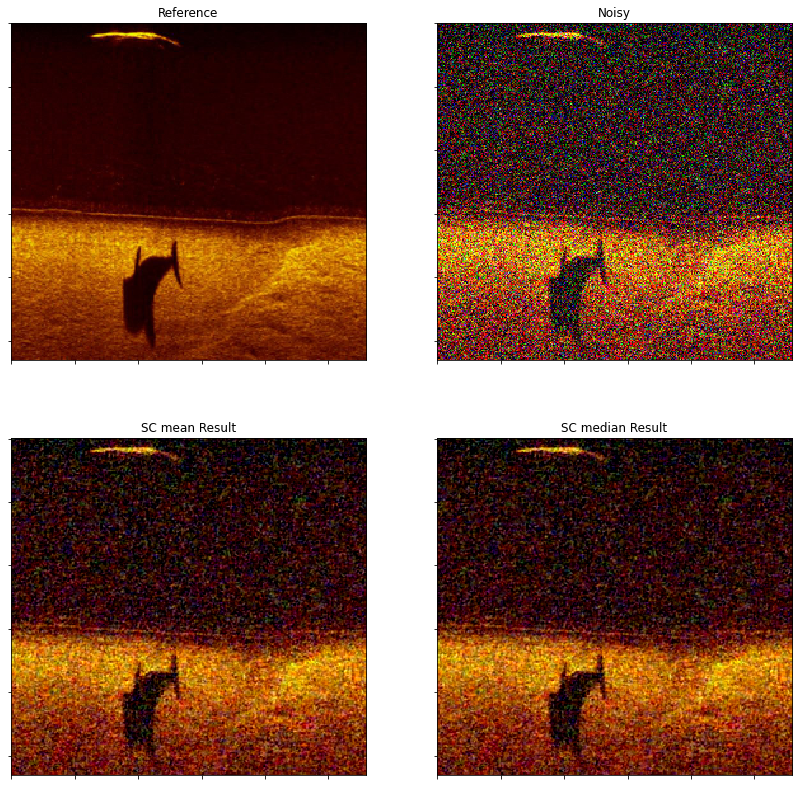

In [57]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(img, title='Reference', fig=fig)
plot.subplot(2, 2, 2)
plot.imview(imgn, title='Noisy', fig=fig)
plot.subplot(2, 2, 3)
plot.imview(imgd_mean, title='SC mean Result', fig=fig)
plot.subplot(2, 2, 4)
plot.imview(imgd_median, title='SC median Result', fig=fig)
fig.show()

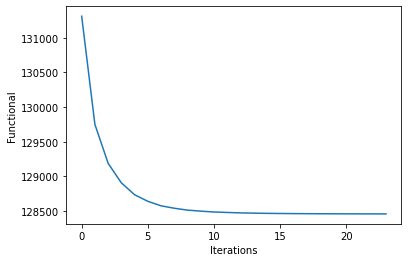

In [58]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')

In [59]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgd_mean,
                  data_range=imgd_mean.max() - imgd_mean.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 


0.23032925547376418
